In [56]:
# linear algebra and data processing
import numpy as np
import pandas as pd 

#data visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# statistics
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# models + accuracy metrics

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# saving models
import pickle
import gzip

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


### Loading Data

In [39]:
# data
na_value=['',' ','nan','Nan','NaN','na', '<Na>']
train = pd.read_csv('../data/train.csv', na_values=na_value)
test = pd.read_csv('../data/test.csv', na_values=na_value)
store = pd.read_csv('../data/store.csv', na_values=na_value)
submission = pd.read_csv('../data/sample_submission.csv', na_values=na_value)
print('train set shape:', train.shape)
print('test set shape:', test.shape)
print('store set shape:', store.shape)

train set shape: (1017209, 9)
test set shape: (41088, 8)
store set shape: (1115, 10)


In [40]:
# merge the train/test sets with the stores set
df_trainS= pd.merge(left = train, right = store, how = 'inner', left_on = 'Store', right_on = 'Store')
df_testS= pd.merge(left = test, right = store, how = 'inner', left_on = 'Store', right_on = 'Store')
print(df_trainS.shape)
print(df_testS.shape)

(1017209, 18)
(41088, 17)


In [41]:
# quick peak
df_trainS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [42]:
df_testS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

### Preprocessing

In [43]:
def preprocess_data(df_trainS, df_testS):
    
    # preprocessing
    global train_features, test_features, train_target, categorical, numerical
    # train and target features
    train_features = df_trainS.drop(['Sales', 'Customers'], axis = 1) #drop the target feature + customers ( will not be used for prediction)
    train_target  = df_trainS[['Sales']]
    test_features = df_testS.drop(['Id'], axis = 1) #drop id, it's required only during submission
    
    #feature generation + transformations
    train_features['Date'] = pd.to_datetime(train_features.Date)
    train_features['Month'] = train_features.Date.dt.month.to_list()
    train_features['Year'] = train_features.Date.dt.year.to_list()
    train_features['Day'] = train_features.Date.dt.day.to_list()
    train_features['WeekOfYear'] = train_features.Date.dt.weekofyear.to_list()
    train_features['DayOfWeek'] = train_features.Date.dt.dayofweek.to_list()
    train_features['weekday'] = 1        # Initialize the column with default value of 1
    train_features.loc[train_features['DayOfWeek'] == 5, 'weekday'] = 0
    train_features.loc[train_features['DayOfWeek'] == 6, 'weekday'] = 0
    train_features = train_features.drop(['Store'], axis = 1)
  

    test_features['Date'] = pd.to_datetime(test_features.Date)
    test_features['Month'] = test_features.Date.dt.month.to_list()
    test_features['Year'] = test_features.Date.dt.year.to_list()
    test_features['Day'] = test_features.Date.dt.day.to_list()
    test_features['WeekOfYear'] = test_features.Date.dt.weekofyear.to_list()
    test_features['DayOfWeek'] = test_features.Date.dt.dayofweek.to_list()
    test_features['weekday'] = 1        # Initialize the column with default value of 1
    test_features.loc[test_features['DayOfWeek'] == 5, 'weekday'] = 0
    test_features.loc[test_features['DayOfWeek'] == 6, 'weekday'] = 0
    test_features = test_features.drop(['Store'], axis = 1)

    # numerical and categorical columns (train set)
    categorical = []
    numerical = []
    timestamp = []
    
    
    for col in train_features.columns:
        if train_features[col].dtype == object:
            categorical.append(col)
        elif train_features[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            numerical.append(col)
        else:
            timestamp.append(col)

    # Keep selected columns only
    my_cols = categorical + numerical + timestamp
    train_features = train_features[my_cols].copy()
    test_features = test_features[my_cols].copy()
    features = pd.concat([train_features, test_features]) #merge the features columns for uniform preprocessing

    # change dtypes for uniformity in preprocessing
    features.CompetitionOpenSinceMonth = features.CompetitionOpenSinceMonth.astype('Int64') 
    features.CompetitionOpenSinceYear = features.CompetitionOpenSinceYear.astype('Int64')
    features.Promo2SinceWeek = features.Promo2SinceWeek.astype('Int64') 
    features.Promo2SinceYear = features.Promo2SinceYear.astype('Int64')
    features["StateHoliday"].loc[features["StateHoliday"] == 0] = "0"

     # numeric
    for col in ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        features[col] = features[col].fillna((int(features[col].mean()))) 
    features.PromoInterval = features.PromoInterval.fillna(features.PromoInterval.mode()[0])
    features.Open = features.Open.fillna(features.Open.mode()[0])        
    features = pd.get_dummies(features, columns=['StoreType', 'Assortment', 'PromoInterval', 'StateHoliday'], drop_first=True)        
    scaler = RobustScaler()

    features[numerical] = scaler.fit_transform(features[numerical].values)


    return features
    

In [44]:

features = preprocess_data(df_trainS, df_testS)
features = features.drop(['Date'], axis = 1)
features.head()

,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
1,0.00,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,-0.25,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,-0.50,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
4,-0.75,0.0,1.0,1.0,-0.172078,0.666667,0.0,-1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [45]:
# reconstruct train and test sets
def reconstruct_sets(features):
    global x_train, x_val, y_train, y_val
    x_train = features.iloc[:len(train_features), :]
    x_test = features.iloc[len(train_features):, :]
    y_train = train_target
    
     # updated train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .20, random_state = 0)
    return x_train, x_val, y_train, y_val,x_test

In [51]:

x_train, x_val, y_train, y_val, x_test = reconstruct_sets(features)
#len(train_features)

In [52]:
# log transformation on target variable
y_train = np.log1p(y_train['Sales'])
y_val = np.log1p(y_val['Sales'])
x_train.shape, x_val.shape, y_train.shape, y_val.shape, x_test.shape

((813767, 25), (203442, 25), (813767,), (203442,), (41088, 25))

In [62]:
y_val

982497    8.188411
719065    8.883640
145542    8.681860
252177    8.921858
479489    0.000000
            ...   
181840    8.259199
349515    9.731572
710927    8.729882
971200    8.112528
14246     8.686598
Name: Sales, Length: 203442, dtype: float64

### Modelling

In [53]:
features.to_csv('features.csv')

In [58]:
# RandiomForestRegressor

#fitting
clf = RandomForestRegressor(n_estimators =21 )
clf.fit(x_train, y_train)

# validation
y_pred = clf.predict(x_val)
print("Mean squared error for RF on validation data =", mean_squared_error(y_val, y_pred))
print("Mean absolute error for RF on validation data =", mean_absolute_error(y_val, y_pred))

Mean squared error for RF on validation data = 0.018030971405377398
Mean absolute error for RF on validation data = 0.07500417121068341


In [63]:
# GradientBooster

#fitting
gdb = GradientBoostingRegressor(random_state = 5)
gdb = gdb.fit(x_train, y_train)

#validation
gdb_pred = gdb.predict(x_val)
print("Mean absolute error for gdb on validation data =", mean_absolute_error(y_val, gdb_pred))
print("Mean squared error for gdb on validation data =", mean_squared_error(y_val, gdb_pred))

Mean absolute error for gdb on validation data = 0.2217410065237111
Mean squared error for gdb on validation data = 0.0966456895614806


In [64]:
# LinearRegression

#fitting
regressor = LinearRegression()
regressor.fit(x_train, y_train)

#validation
# scores = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 5)
regressor_pred = regressor.predict(x_val)
print("Mean squared error for sLR on validation data =", mean_squared_error(y_val, regressor_pred))
print("Mean absolute error for SLR on validation data =", mean_absolute_error(y_val, regressor_pred))

Mean squared error for sLR on validation data = 0.11848353838194997
Mean absolute error for SLR on validation data = 0.25272612891484786


In [65]:
# ExtremeBooster

#fitting
xgb = XGBRegressor(random_state = 42)
xgb.fit(x_train, y_train)

# validation
# scores = cross_val_score(estimator = xgb, X = x_train, y = y_train, cv = 5)
xgb_pred = xgb.predict(x_val)
print("Mean absolute error for xgb on validation data =", mean_absolute_error(y_val, xgb_pred))
print("Mean squared error for xgb on validation data =", mean_squared_error(y_val, xgb_pred))

Mean absolute error for xgb on validation data = 0.12452821718981405
Mean squared error for xgb on validation data = 0.03187673969685498


Text(0.5, 1.0, 'MSE scores in the 4 models')

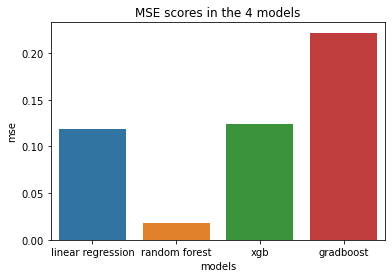

In [66]:
# Models performance
data = {'models':['linear regression', 'random forest', 'xgb', 'gradboost'], 
        'mse':[0.11848353838194997, 0.018030971405377398, 0.12452821718981405,0.2217410065237111 ],
        'mae':[0.25272612891484786, 0.07500417121068341,0.03187673969685498,0.0966456895614806]}
performance = pd.DataFrame(data, columns = ['models', 'mse', 'mae'])
sns.barplot(x = performance.models,  y = performance.mse)
plt.title('MSE scores in the 4 models')

Text(0.5, 1.0, 'MAE scores in the 4 models')

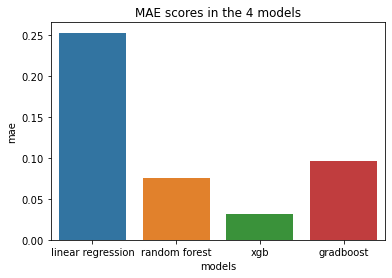

In [67]:
sns.barplot(x = performance.models,  y = performance.mae)
plt.title('MAE scores in the 4 models')

#### Random Forest and XGB have a good performance. Going the MSE way: RandomForest is the ideal one.

In [68]:
# save the model
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)
        
save_zipped_pickle(clf, 'compressed.pkl') #rf
save_zipped_pickle(xgb, 'compressed_xgb.pkl') #xgb
save_zipped_pickle(gdb, 'compressed_gb.pkl') #gb
save_zipped_pickle(regressor , 'compressed.pkl') #linearR

### Predictions

In [73]:
# make predictions using the random forest model
final_pred = clf.predict(x_test)
final_pred.shape

(41088,)

In [81]:
'''reconstruct a df with StoreID, date and Sales columns using the predcitions and the test set then save it as a csv file'''

sub = df_testS[['Id']]
back = np.expm1(final_pred)
sub['Sales'] = back
sub['Date'] = df_testS.Date.to_list()
sub['Store'] = df_testS.Store.to_list()
sub.to_csv('sub_plot.csv', index = False)


### Pred Plot

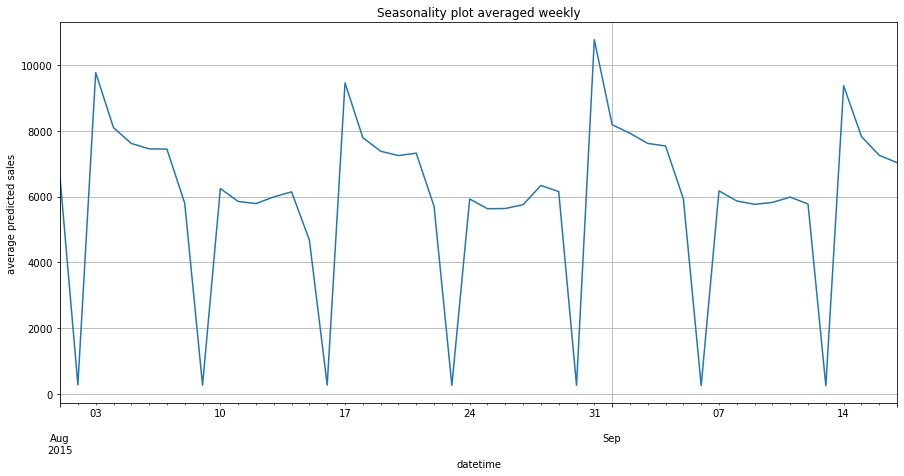

In [84]:
time_data = sub[['Date', 'Sales']]
time_data['datetime'] = pd.to_datetime(time_data['Date'])
time_data = time_data.set_index('datetime')
time_data = time_data.drop(['Date'], axis = 1)
monthly_time_data = time_data.Sales.resample('D').mean() 
plt.figure(figsize = (15,7))
plt.title('Seasonality plot averaged weekly')
plt.ylabel('average predicted sales')
monthly_time_data.plot()
plt.grid()